<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/The_Oracle_Project_Predictive_Customer_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Oracle Project Predictive Customer Intelligence

### Project Overview

* Develops a predictive business intelligence tool to forecast future customer behavior from transactional data.
* Uses a **Beta-Geometric (BG/NBD)** statistical model to predict the number of future purchases for each customer.
* Employs a **Gamma-Gamma** model to estimate the future monetary value of those purchases, leading to a **Customer Lifetime Value (CLV)** prediction.
* Trains a **Random Forest** machine learning model to calculate the **Churn Risk** (probability of a customer leaving) based on their predicted value and purchasing habits.
* The final output is a **Strategic Customer Segmentation Matrix** that visually categorizes customers based on their predicted value versus their risk of churning.

***

### Purpose of the Project

* To create a forward-looking "oracle" that moves beyond historical reporting ("what happened") to predictive intelligence ("what will happen").
* To provide a **data-driven framework** for prioritizing customers, enabling a business to focus its most valuable resources on the right segments.
* To empower strategic decision-making by identifying key customer groups, such as "VIPs at High Risk" or "High Potentials," allowing for targeted and effective actions.
* To create **actionable intelligence** that directly informs marketing, sales, and retention strategies to maximize profitability and ensure sustainable growth.



## Install necessary libraries

In [2]:
!pip install pandas numpy scikit-learn lifetimes seaborn matplotlib -q
print("Libraries installed")

Libraries installed


## Import libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter, BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt
import seaborn as sns
print("Imported")

Imported


## Load and Prepare the Dataset

* We will use the CDNOW dataset, which is a classic dataset for CLV analysis.

* It contains the transaction history for a cohort of customers.

In [5]:
summary = load_cdnow_summary_data_with_monetary_value()
summary.rename(columns={'frequency': 'frequency_cal', 'recency': 'recency_cal', 'T': 'T_cal', 'monetary_value': 'monetary_value_cal'}, inplace=True)

### Sample of the Customer Dataset

- frequency_cal: Number of repeat purchases
- recency_cal: Age of the customer at their last purchase
- T_cal: Age of the customer in days
- monetary_value_cal: Average value of a customer's purchases

In [7]:
print(summary.head())

             frequency_cal  recency_cal  T_cal  monetary_value_cal
customer_id                                                       
1                        2        30.43  38.86               22.35
2                        1         1.71  38.86               11.77
3                        0         0.00  38.86                0.00
4                        0         0.00  38.86                0.00
5                        0         0.00  38.86                0.00


## Model Future Transactions with Beta-Geometric (BG/NBD) Model

In [8]:
# predicts the number of future purchases
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency_cal'], summary['recency_cal'], summary['T_cal'])

# Predict the number of purchases in the next 90 days
t = 90 # days
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency_cal'], summary['recency_cal'], summary['T_cal'])
print(summary.sort_values(by='predicted_purchases', ascending=False).head())

             frequency_cal  recency_cal  T_cal  monetary_value_cal  \
customer_id                                                          
1516                    26        30.86  31.00               39.97   
157                     29        37.71  38.00               26.26   
841                     19        34.00  34.14               29.49   
1981                    17        28.43  28.86               48.23   
509                     18        35.14  35.86               78.63   

             predicted_purchases  
customer_id                       
1516                   37.683818  
157                    37.153033  
841                    26.089972  
1981                   25.557312  
509                    23.711534  


## Model Customer Lifetime Value (CLV) with Gamma-Gamma Model

In [12]:
# Consider customers who have made repeat purchases
returning_customers_summary = summary[summary['frequency_cal'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(returning_customers_summary['frequency_cal'], returning_customers_summary['monetary_value_cal'])

# Predict the CLV for the next 90 days
summary['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency_cal'],
    summary['recency_cal'],
    summary['T_cal'],
    summary['monetary_value_cal'],
    time=3, # 3 months
    discount_rate=0.01 # monthly discount rate
)

print('Top 10 Most Valuable Customers')
print(summary.sort_values(by='predicted_clv', ascending=False).head(10))

Top 10 Most Valuable Customers
             frequency_cal  recency_cal  T_cal  monetary_value_cal  \
customer_id                                                          
509                     18        35.14  35.86               78.63   
1081                    11        32.00  33.14              106.53   
1516                    26        30.86  31.00               39.97   
1560                     8        28.71  30.86              117.46   
1981                    17        28.43  28.86               48.23   
801                      7        33.71  34.43              124.61   
157                     29        37.71  38.00               26.26   
164                     10        37.00  37.86               62.44   
841                     19        34.00  34.14               29.49   
1365                     9        30.57  31.71               61.41   

             predicted_purchases  predicted_clv        churn  
customer_id                                                   
50

## Model Churn Risk

In [11]:
# Synthetic 'churn' column
churn_threshold_purchases = summary['predicted_purchases'].quantile(0.2)
churn_threshold_clv = summary['predicted_clv'].quantile(0.2)

summary['churn'] = 'Not Churned'
summary.loc[(summary['predicted_purchases'] < churn_threshold_purchases) & (summary['predicted_clv'] < churn_threshold_clv), 'churn'] = 'Churned'

# Prepare data for the classification model
features = ['recency_cal', 'T_cal', 'monetary_value_cal', 'predicted_purchases']
X = summary[features]
y = summary['churn']

# Handle potential NaN values in features
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Evaluate the churn model
y_pred = rf_classifier.predict(X_test)
print("Business Intelligence: Churn Prediction Model Evaluation")
print(classification_report(y_test, y_pred))


Business Intelligence: Churn Prediction Model Evaluation
              precision    recall  f1-score   support

     Churned       0.99      0.99      0.99       117
 Not Churned       1.00      1.00      1.00       591

    accuracy                           1.00       708
   macro avg       0.99      0.99      0.99       708
weighted avg       1.00      1.00      1.00       708



## Generate Actionable Business Intelligence

* The Oracle Project: Actionable Business Intelligence


Strategic Customer Segmentation Matrix


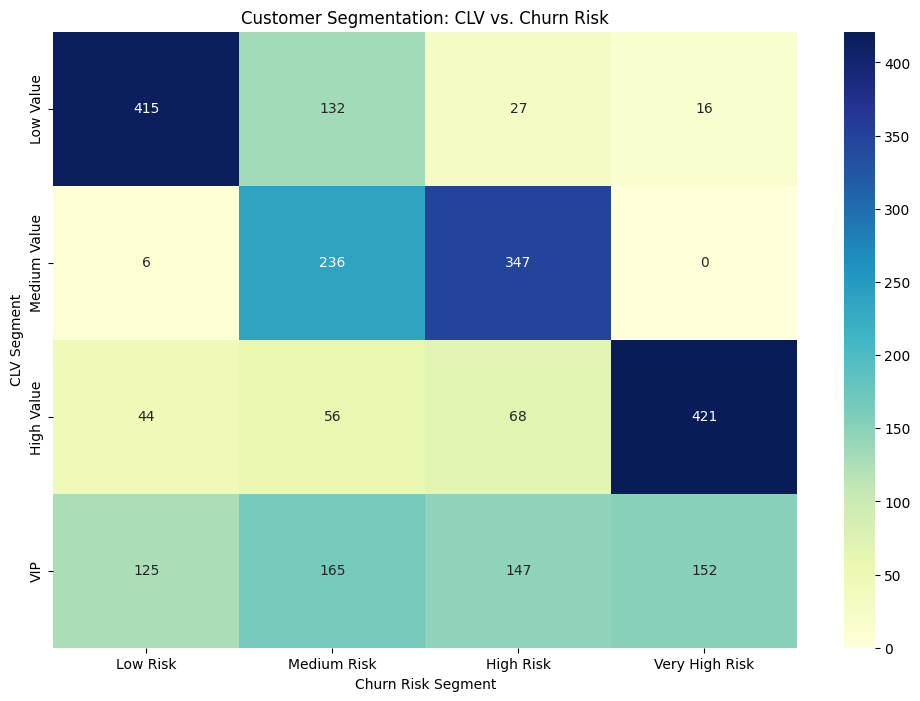

In [13]:
# Segment customers based on CLV and Churn Risk
summary['clv_segment'] = pd.qcut(summary['predicted_clv'].rank(method='first'), q=4, labels=['Low Value', 'Medium Value', 'High Value', 'VIP'])

# Predict churn probability for the entire dataset
summary['churn_probability'] = rf_classifier.predict_proba(X[features])[:, 1]
summary['churn_risk_segment'] = pd.qcut(summary['churn_probability'].rank(method='first'), q=4, labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

# Create a strategic customer segmentation matrix
customer_segments = summary.groupby(['clv_segment', 'churn_risk_segment']).size().unstack(fill_value=0)

print("\nStrategic Customer Segmentation Matrix")
plt.figure(figsize=(12, 8))
sns.heatmap(customer_segments, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Customer Segmentation: CLV vs. Churn Risk')
plt.ylabel('CLV Segment')
plt.xlabel('Churn Risk Segment')
plt.show()


## Strategic Recommendations

**1. VIPs at High Risk (High Value, High Risk):**
   - **Action:** Proactive Retention Campaign. Assign a dedicated account manager, offer exclusive discounts, or provide loyalty rewards.
   - **BI Insight:** These are your most valuable customers who are about to leave. The ROI on retaining them is highest.

**2. High Potential (High Value, Low Risk):**
   - **Action:** Nurture and Upsell. Introduce them to new products, premium services, or loyalty programs to further increase their value.
   - **BI Insight:** These are your brand champions. Leverage them for testimonials and referrals.

**3. At-Risk Potentials (Medium Value, High Risk):**
   - **Action:** Automated Retention. Send personalized emails with special offers or conduct surveys to understand their dissatisfaction.
   - **BI Insight:** A targeted, automated campaign can efficiently retain this group without overspending.

**4. Low Value, Low Risk:**
   - **Action:** Monitor and Maintain. Keep them engaged with standard marketing communications. No need for expensive, personalized outreach.
   - **BI Insight:** This group is stable but provides lower returns. A low-cost communication strategy is most effective.
